Two questions were asked last lecture that I felt deserved a more thorough (and better) response:

**Question 1:** 
Does the padding affect the convolution, because if we convolve two kernels together we get a smaller output without padding.  But the math doesn't take padding into account?

Theoretical:
Convolution theorem states that convolution is always:

Commutative: $x_1 (t) * x_2 (t) = x_2 (t) * x_1 (t)$
Associative: $x_1 (t) * [x_2 (t) * x_3 (t) ] = [x_1 (t) * x_2 (t)] * x_3 (t)$

The proof assumes that the signal domain (1D or 2D) is an infinite space.  So does padding make a difference?  No, if you consider the padding as part of the infinite space.  In that scenario, the input signal signal does not change as the padding is as long as the **padding is the same for ALL the kernel(s) and image.**

In [1]:
# Import libraries required to do operations like convolution, gaussian blur, sobel operator, pixel manipulation, etc.
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (40,10)

#Simple case where we have an "image" on one pixel
I = np.array([[100]], dtype=np.uint8)

#Approximate Gaussian Kernel
k1 = np.array([[1,2,1],
               [2,4,2],
               [1,2,1]]) * 1/16

#Unit kernel
alpha = 1.
k2 = np.array([[0,0,0],
               [0,1,0],
               [0,0,0]]) * alpha

#Perform the convolution, don't need to rotate 180 because our kernels are symmetric
#But if we did you can do: np.flipud(np.fliplr(k2))
k = cv2.filter2D(k1, -1, k2, borderType=cv2.BORDER_CONSTANT) #BORDER_CONSTANT will pad with 0 by default
print(f"k1 * k2 = \n{k}")

k1 * k2 = 
[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]


In [2]:
#Apply the k1 * k2 to I
I_p = cv2.filter2D(I, -1, k, borderType=cv2.BORDER_CONSTANT)

#Perform (I*k1) * k2
I_x = cv2.filter2D(cv2.filter2D(I, -1, k1, borderType=cv2.BORDER_CONSTANT), -1, k2, borderType=cv2.BORDER_CONSTANT)

#Check if there are any differences in the output
I_diff = I_p - I_x
print(f"Image * k: {I_p}")
print(f"Image * k1 * k2 = {I_x}")
print(f"Differences: {np.sum(I_diff)}") #Nope!

Image * k: [[25]]
Image * k1 * k2 = [[25]]
Differences: 0


**Counter proof:** What happens when we change the padding on the Image I, therefore, breaking the commonality of the infinite space (i.e. padding).

In [3]:
#Apply the k1 * k2 to I
I_p = cv2.filter2D(I, -1, k, borderType=cv2.BORDER_REFLECT)
#Check if there are any differences in the output
I_diff = I_p - I_x
print(f"Image * k: {I_p}")
print(f"Image * k1 * k2 = {I_x}")
print(f"Differences: {np.sum(I_diff)}") #Yup!

Image * k: [[100]]
Image * k1 * k2 = [[25]]
Differences: 75


**Question 2:**
When two different Gaussian kernels, $G_{\sigma_1}$ , $G_{\sigma_2}$ are convolved, the result is also a Gaussian $G_{\sigma_1 + \sigma_2}$.  This is because the Fourier transform of a Gaussian is always a Gaussian and the Fourier transform of convolution product equal to the pointwise product of the Fourier transforms.

i.e. The convolution for $g * h$ is equivalent to the pointwise multiplication of their Fourier transformed signals $G(f) \cdot H(f)$

Now, with Gaussian kernels we assume origin (0,0) is at the center pixel (i.e. $\mu$ is 0).  **NOTE:** In most cases, the origin is the upper-left.  So if we move the kernel that should be the equivallent of changing $mu$.  That means, the resultant should be a Gaussian.

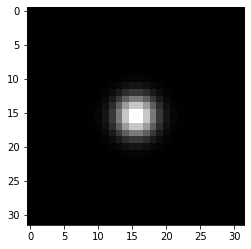

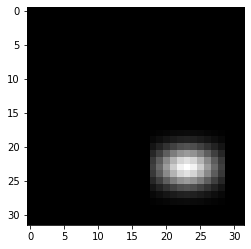

0.9940524285918735


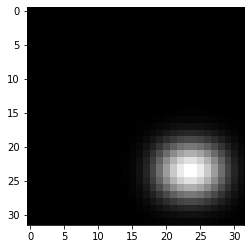

In [4]:
#This function returns a 1D kernel (because Gaussian kernsl are seperable), so do outer product to get 2D kernel
k1 = cv2.getGaussianKernel(32, 2)
k1 = k1 * k1.T
k2X = cv2.getGaussianKernel(11, 2) #To make a kernel with sigma difference in X,Y directions
k2Y = cv2.getGaussianKernel(11, 3)
k2 = k2X * k2Y.T


k2 = cv2.copyMakeBorder(k2, top=(32-14),bottom=3,left=(32-14),right=3, borderType=cv2.BORDER_CONSTANT)

plt.imshow(k1, cmap='gray')
plt.show()
plt.imshow(k2, cmap='gray')
plt.show()

#Rotate 180 degrees (flip horizontally and vertically)
k2 = np.flipud(np.fliplr(k2))
k = cv2.filter2D(k1, -1, k2, borderType=cv2.BORDER_CONSTANT) 
print(k.sum())
plt.imshow(k, cmap='gray')
plt.show()


To further show why this works, let's look at the Discrete Fourier Transform (magnitude spectrum) to show that all the kernels are Gaussian in Fourier space. If we compare the DFT of the two kernels and do a pointwise convolution, we should get the DFT of the convolution of k1 and k2.


$\mathcal{F}\lbrace f * g \rbrace = \mathcal{F}\lbrace f \rbrace \cdot \mathcal{F} \lbrace g \rbrace$, where
$f$ is k1, $g$ is k2 and $\mathcal{F}\lbrace f * g \rbrace$ is k.

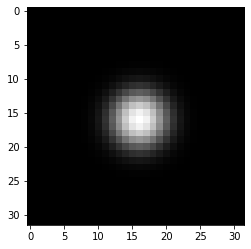

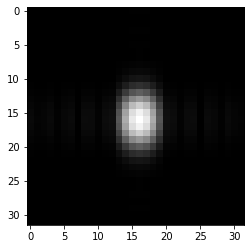

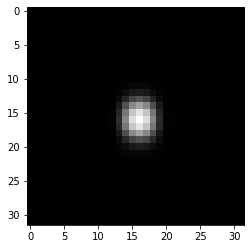

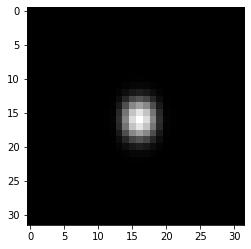

In [5]:
def magnitude(z):
    return np.log(np.abs(z)+1)
    
fft_filters = [np.fft.fft2(x) for x in [k1,k2,k]] #Apply fourier transform
fft_shift = [np.fft.fftshift(y) for y in fft_filters] #Bring the signals to the center
mag_spectrum = [ magnitude(z) for z in fft_shift] #Calculate the magnitude spectrum from the frequency tranform for output

#Perform the 
k_fft = np.multiply(*fft_filters[:2])
k_fft_shifted = np.fft.fftshift(k_fft)
k_mag = magnitude(k_fft_shifted)
mag_spectrum.append(k_mag)


for ms in mag_spectrum:
    plt.imshow(ms, cmap='gray')
    plt.show()


In [6]:
#Visually the last two look identical, but let's check quantatively
compare = (k_mag - mag_spectrum[-1]).sum()
print(f"Is the result identical? {compare}") #Yup :)


Is the result identical? 0.0
